**Chosica DSM to Hybrid DSM-DTM Conversion Pipeline**

In [ ]:
#Google Drive mount (same as Lagasca)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#libraries installation
!pip install numpy scipy pandas matplotlib tqdm \
             scikit-image scikit-learn \
             torch torchvision torchmetrics \
             segmentation-models-pytorch \
             albumentations==1.3.0 \
             rasterio geopandas shapely fiona pyproj rtree tifffile \
             pillow rich --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 30.7 MB/s eta 0:00:00


In [ ]:
#Import libraries
import os
import rasterio
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling
from rasterio.fill import fillnodata
from scipy.ndimage import median_filter, gaussian_filter, binary_opening,binary_closing, binary_dilation, label, uniform_filter

In [ ]:
"""
Input/Output file paths updated for Chosica site:
"""

BASE_DIR = "/content/drive/MyDrive"
SITE     = "chosica"
DSM_TIF   = f"{BASE_DIR}/chosica/demchosica.tif"
ORTHO_TIF = f"{BASE_DIR}/chosica/orthochosica.tif"

WORK_DIR   = f"{BASE_DIR}/{SITE}"
TILES_DIR  = f"{WORK_DIR}/Tiles"
INPUTS_DIR = f"{TILES_DIR}/inputs"
VALID_DIR  = f"{TILES_DIR}/valid"
PREDS_DIR  = f"{TILES_DIR}/preds"
OUT_DIR    = f"{WORK_DIR}/Outputs"
for d in [INPUTS_DIR, VALID_DIR, PREDS_DIR, OUT_DIR]:
    os.makedirs(d, exist_ok=True)

# Reuses the SAME trained weights for Lagasca
MODEL_BEST_PATH = f"{BASE_DIR}/Project/checkpoints/unetlite_best_state_dict.pth"  # <-- points to the working Lagasca .pth

# Inference threshold (same as chosen before)
BEST_THR = 0.70

print("DSM_TIF:", DSM_TIF)
print("ORTHO_TIF:", ORTHO_TIF)
print("MODEL_BEST_PATH:", MODEL_BEST_PATH)
print("OUT_DIR:", OUT_DIR)


DSM_TIF: /content/drive/MyDrive/chosica/demchosica.tif
ORTHO_TIF: /content/drive/MyDrive/chosica/orthochosica.tif
MODEL_BEST_PATH: /content/drive/MyDrive/Project/checkpoints/unetlite_best_state_dict.pth
OUT_DIR: /content/drive/MyDrive/chosica/Outputs


In [ ]:
# Align orthoimage to DSM grid

ORTHO_ALIGNED = f"{OUT_DIR}/{SITE}_ORTHO_aligned.tif"

with rasterio.open(DSM_TIF) as ref, rasterio.open(ORTHO_TIF) as src:
    profile = ref.profile.copy()
    profile.update(driver="GTiff", count=min(3, src.count), dtype=rasterio.uint8, compress="lzw")
    profile.pop("nodata", None)

    same_grid = (ref.crs == src.crs and ref.transform == src.transform
                 and ref.width == src.width and ref.height == src.height)

    if same_grid:
        with rasterio.open(ORTHO_ALIGNED, "w", **profile) as dst:
            for b in range(1, profile["count"]+1):
                dst.write(src.read(b), b)
        print("Saved aligned copy:", ORTHO_ALIGNED)
    else:
        with WarpedVRT(src, crs=ref.crs, transform=ref.transform,
                       width=ref.width, height=ref.height,
                       resampling=Resampling.bilinear) as vrt, \
             rasterio.open(ORTHO_ALIGNED, "w", **profile) as dst:
            for b in range(1, profile["count"]+1):
                dst.write(vrt.read(b), b)
        print("Saved warped (aligned):", ORTHO_ALIGNED)



Saved warped (aligned): /content/drive/MyDrive/chosica/Outputs/chosica_ORTHO_aligned.tif


In [ ]:
# TILING

tile_size = 256
stride = 256
min_valid_pixels = 50   # skip tiles with fewer valid pixels than this

ortho_path = "/content/drive/MyDrive/chosica/orthochosicaaligned.tif"
dem_path   = "/content/drive/MyDrive/chosica/demchosica.tif"
output_root = "/content/drive/MyDrive/chosica/Tiles"
input_dir = os.path.join(output_root, "inputs")
os.makedirs(input_dir, exist_ok=True)

with rasterio.open(ortho_path) as ortho_src, rasterio.open(dem_path) as dem_src:
    rgb = ortho_src.read([1, 2, 3]).astype(np.float32)  # R,G,B
    dem = dem_src.read(1).astype(np.float32)

    if dem_src.nodata is not None:
        dem = np.where(dem == dem_src.nodata, 0, dem)

    H, W = dem.shape
    print(f"Raster size: {H}x{W}")

    tile_id = 0
    print("Tiling started...")

    for i in tqdm(range(0, H - tile_size + 1, stride)):
        for j in range(0, W - tile_size + 1, stride):
            rgb_tile = rgb[:, i:i+tile_size, j:j+tile_size]
            dem_tile = dem[i:i+tile_size, j:j+tile_size]

            if np.count_nonzero(dem_tile) < min_valid_pixels:
                continue

            input_tile = np.concatenate([rgb_tile, dem_tile[np.newaxis, ...]], axis=0)

            input_path = os.path.join(input_dir, f"tile_{tile_id:05d}.npy")
            np.save(input_path, input_tile)

            tile_id += 1

print(f"Tiling complete. {tile_id} valid tiles saved to {input_dir}")

Raster size: 8479x6859
Tiling started...


100%|██████████| 33/33 [00:08<00:00,  3.78it/s]

Tiling complete. 652 valid tiles saved to /content/drive/MyDrive/chosica/Tiles/inputs


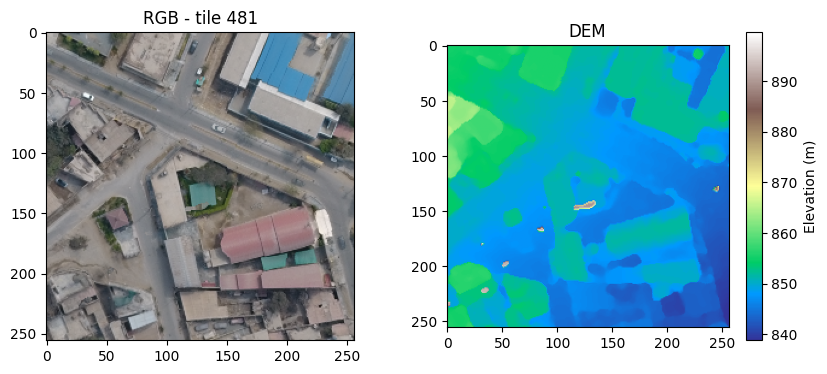

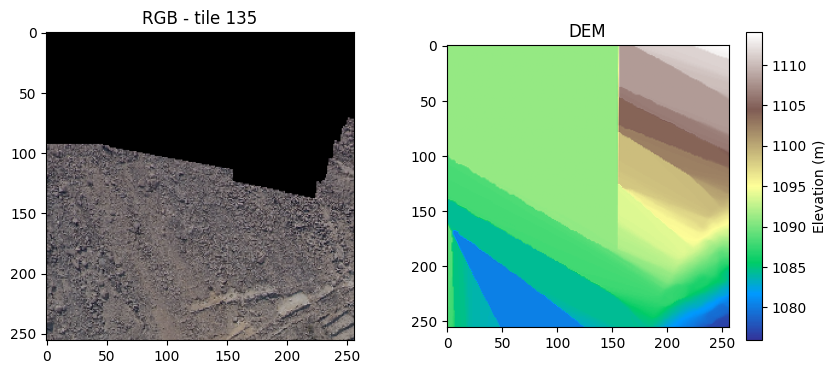

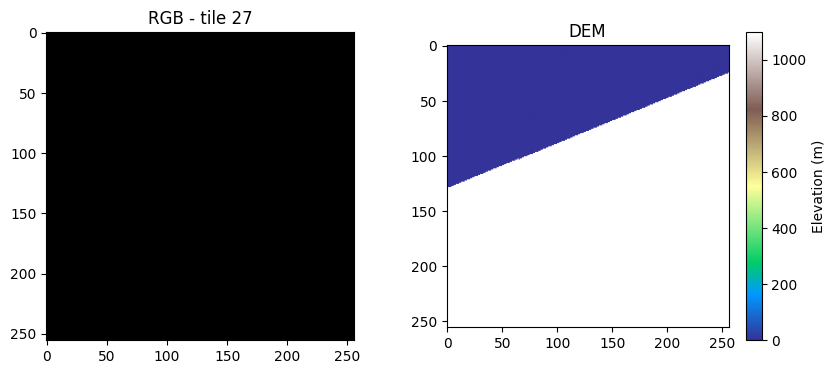

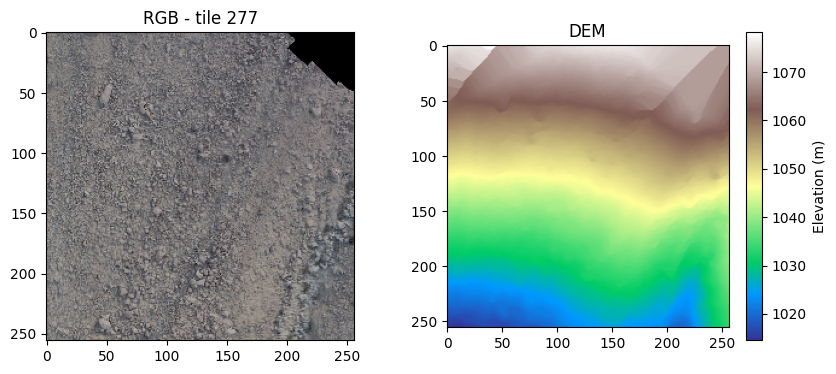

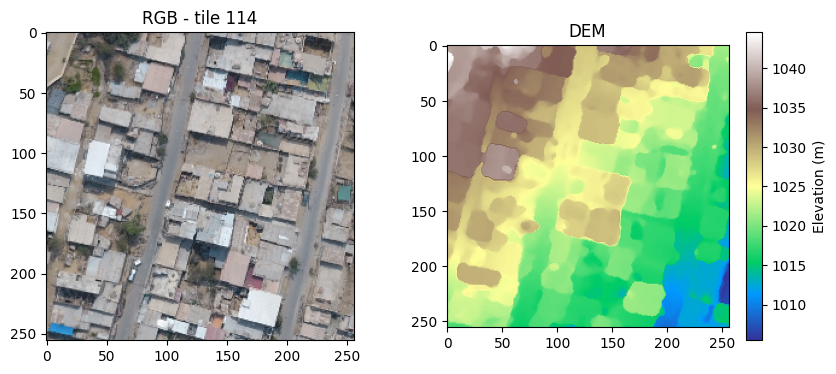

In [ ]:
# VISUALIZE RANDOM TILES

input_dir = "/content/drive/MyDrive/chosica/Tiles/inputs"

tile_ids = sorted([
    int(f.split("_")[1].split(".")[0])
    for f in os.listdir(input_dir) if f.endswith(".npy")
])

samples = random.sample(tile_ids, min(5, len(tile_ids)))

for tile_id in samples:
    input_path = os.path.join(input_dir, f"tile_{tile_id:05d}.npy")
    input_tile = np.load(input_path)

    # Split into Ortho + DEM
    rgb = input_tile[:3].transpose(1, 2, 0).astype(np.uint8)
    dem = input_tile[3]

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(rgb)
    plt.title(f"Ortho-Imagery - tile {tile_id}")

    plt.subplot(1, 2, 2)
    plt.imshow(dem, cmap="terrain")
    plt.colorbar(label="Elevation (m)")
    plt.title("DEM")

    plt.show()


In [ ]:
# MODEL

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class UNetLite(nn.Module):
    def __init__(self, in_channels=4, out_channels=1, features=[32,64,128,256]):
        super().__init__()
        self.downs = nn.ModuleList(); self.ups = nn.ModuleList()
        self.pool  = nn.MaxPool2d(2,2)
        ch = in_channels
        for f in features:
            self.downs.append(ConvBlock(ch, f)); ch = f
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)
        for f in reversed(features):
            self.ups.append(nn.ConvTranspose2d(f*2, f, 2, 2))
            self.ups.append(ConvBlock(f*2, f))
        self.final = nn.Conv2d(features[0], out_channels, 1)
    def forward(self, x):
        skips = []
        for d in self.downs:
            x = d(x); skips.append(x); x = self.pool(x)
        x = self.bottleneck(x); skips = skips[::-1]
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            s = skips[i//2]
            if x.shape[-2:] != s.shape[-2:]:
                diffY = s.size(2) - x.size(2); diffX = s.size(3) - x.size(3)
                x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
            x = torch.cat([s, x], dim=1)
            x = self.ups[i+1](x)
        return self.final(x)

# Model configs
IN_CHANNELS = 4    # RGB (3) + DEM (1)
OUT_CHANNELS = 1   # binary vegetation mask
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = UNetLite(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS).to(DEVICE)

In [ ]:
MODEL_BEST_PATH = "/content/drive/MyDrive/Project/checkpoints/unetlite_best_state_dict.pth"

model.load_state_dict(torch.load(MODEL_BEST_PATH, map_location=DEVICE))
model.eval()
print("Loaded weights from:", MODEL_BEST_PATH)


Loaded weights from: /content/drive/MyDrive/Project/checkpoints/unetlite_best_state_dict.pth


In [ ]:
# PREDICTED TILES


TILES_INPUT = "/content/drive/MyDrive/chosica/Tiles/inputs"
PRED_DIR    = "/content/drive/MyDrive/chosica/Tiles/preds"
os.makedirs(PRED_DIR, exist_ok=True)

PRED_THRESH = 0.70  # same used for Lagasca

sigmoid = nn.Sigmoid()

tile_files = sorted([f for f in os.listdir(TILES_INPUT) if f.endswith(".npy")])
print(f"Running inference on {len(tile_files)} tiles...")

for f in tqdm(tile_files):
    tile = np.load(os.path.join(TILES_INPUT, f))  # shape: (4, H, W)
    x = torch.from_numpy(tile).unsqueeze(0).float().to(DEVICE)

    with torch.no_grad():
        pred = model(x)
        pred = sigmoid(pred)[0,0].cpu().numpy()  # (H, W)
        pred_bin = (pred > PRED_THRESH).astype(np.uint8)

    out_path = os.path.join(PRED_DIR, f.replace(".npy", "_pred.npy"))
    np.save(out_path, pred_bin)

print(f"Inference complete. Predictions saved to {PRED_DIR}")


Running inference on 652 tiles...


100%|██████████| 652/652 [06:02<00:00,  1.80it/s]

Inference complete. Predictions saved to /content/drive/MyDrive/chosica/Tiles/preds


In [ ]:
# PREDICTION MASK - TILE STITCHING


TILES_INPUT = "/content/drive/MyDrive/chosica/Tiles/inputs"
PRED_DIR    = "/content/drive/MyDrive/chosica/Tiles/preds"
DEM_TIF     = "/content/drive/MyDrive/chosica/demchosica.tif"
OUT_MASK    = "/content/drive/MyDrive/chosica/chosica_pred_mask.tif"

with rasterio.open(DEM_TIF) as src:
    H, W = src.height, src.width
    tr, crs = src.transform, src.crs

full_mask = np.zeros((H, W), dtype=np.uint8)

sample_tile = np.load(os.path.join(PRED_DIR, os.listdir(PRED_DIR)[0]))
tile_h, tile_w = sample_tile.shape


for f in tqdm(sorted(os.listdir(PRED_DIR))):
    if not f.endswith(".npy"): continue
    tile = np.load(os.path.join(PRED_DIR, f))  # binary mask (0/1)

    tid = int(f.split("_")[1])
    row = tid // (W // tile_w)
    col = tid %  (W // tile_w)

    y0, y1 = row*tile_h, row*tile_h + tile_h
    x0, x1 = col*tile_w, col*tile_w + tile_w

    full_mask[y0:y1, x0:x1] = tile


meta = {"driver":"GTiff","height":H,"width":W,"count":1,
        "dtype":"uint8","crs":crs,"transform":tr,"compress":"LZW"}
with rasterio.open(OUT_MASK, "w", **meta) as dst:
    dst.write(full_mask, 1)

print("Fixed full mask saved:", OUT_MASK)


100%|██████████| 652/652 [00:05<00:00, 111.00it/s]


Fixed full mask saved: /content/drive/MyDrive/chosica/chosica_pred_mask.tif


In [ ]:
# CLEAN PREDICTION MASK (like Lagasca)


PRED_MASK = "/content/drive/MyDrive/chosica/chosica_pred_mask.tif"
CLEAN_MASK = "/content/drive/MyDrive/chosica/chosica_pred_mask_cleaner.tif"

# KNOBS (Tuned according to Chosica site)
OPEN_ITERS   = 1
CLOSE_ITERS  = 2
DILATE_ITERS = 1
MIN_AREA_PX  = 200

with rasterio.open(PRED_MASK) as src:
    pred = src.read(1).astype(np.uint8)
    meta = src.meta.copy()

m = pred > 0
m = binary_opening(m, iterations=OPEN_ITERS)
m = binary_closing(m, iterations=CLOSE_ITERS)
if DILATE_ITERS > 0:
    m = binary_dilation(m, iterations=DILATE_ITERS)

L, n = label(m.astype(np.uint8))
if n > 0:
    counts = np.bincount(L.ravel())
    keep = np.where(counts >= MIN_AREA_PX)[0]
    keep = keep[keep != 0]
    m_clean = np.isin(L, keep).astype(np.uint8)
else:
    m_clean = m.astype(np.uint8)

meta.update({"dtype": "uint8", "compress": "lzw"})
with rasterio.open(CLEAN_MASK, "w", **meta) as dst:
    dst.write(m_clean, 1)

print("Cleaned mask saved:", CLEAN_MASK)
print("Coverage (fraction of area):", m_clean.mean())


Cleaned mask saved: /content/drive/MyDrive/chosica/chosica_pred_mask_cleaner.tif
Coverage (fraction of area): 0.6702231550307879


In [ ]:
# Vegetation Booster Hybrid

DEM_TIF   = "/content/drive/MyDrive/chosica/demchosica.tif"
ORTHO_TIF = "/content/drive/MyDrive/chosica/orthochosicaaligned.tif"
BASE_MASK = "/content/drive/MyDrive/chosica/chosica_pred_mask_cleaner.tif"
OUT_DIR   = "/content/drive/MyDrive/chosica/Outputs"
MASK_OUT  = f"{OUT_DIR}/Chosica_pred_mask_VEGBOOST.tif"
DTM_OUT   = f"{OUT_DIR}/Chosica_DTM_VEGBOOST_SAFE.tif"
DIFF_OUT  = f"{OUT_DIR}/Chosica_DEM_minus_DTM_VEGBOOST_SAFE.tif"
os.makedirs(OUT_DIR, exist_ok=True)

# KNOBS (Tuned according to Chosica)
HAG_MIN_M   = 0.8
ROUGH_WIN_M = 4.5
ROUGH_THR_M = 0.40
LOCAL_GROUND_M = 10.0
EXG_PCT = 70
VARI_PCT = 70
OPEN_ITERS   = 2
CLOSE_ITERS  = 2
DILATE_ITERS = 2
MIN_AREA_M2  = 8.0
GAUSS_SIGMA      = 1.2
FILL_MAX_DIST_M  = 150
MAX_DROP_M       = 60.0


with rasterio.open(DEM_TIF) as dem_src, rasterio.open(ORTHO_TIF) as ortho_src, rasterio.open(BASE_MASK) as msrc:
    dem = dem_src.read(1).astype(np.float32)
    H, W = dem_src.height, dem_src.width
    tr, crs = dem_src.transform, dem_src.crs
    px, py = abs(tr.a), abs(tr.e)
    base = (msrc.read(1) > 0)

    with WarpedVRT(ortho_src, crs=crs, transform=tr, width=W, height=H, resampling=Resampling.bilinear) as ov:
        rgb = ov.read([1,2,3]).astype(np.float32)
        alpha = ov.read_masks(1)[0] > 0

# exg_vari: vegetation indices (ExG, VARI)
def exg_vari(rgb):
    r,g,b = rgb / (255.0 if rgb.max()>1.5 else 1.0)
    exg = 2*g - r - b
    vari = (g - r) / (g + r - b + 1e-6)
    return exg.astype(np.float32), vari.astype(np.float32)

# local_std: roughness measure
def local_std(arr, win_px):
    win = int(max(3, win_px))
    m1  = uniform_filter(arr, size=win, mode="nearest")
    m2  = uniform_filter(arr*arr, size=win, mode="nearest")
    var = np.maximum(0.0, m2 - m1*m1)
    return np.sqrt(var, dtype=np.float32)

# safe_percentile: robust percentile calculation
def safe_percentile(arr, mask, pct, fallback=0.0):
    if mask is not None:
        a = arr[mask]; a = a[np.isfinite(a)]
    else:
        a = arr[np.isfinite(arr)]
    if a.size == 0:
        return fallback
    lo, hi = np.percentile(a, [2,98])
    a = a[(a>=lo) & (a<=hi)]
    return float(np.percentile(a, pct)) if a.size>0 else fallback

win_g = int(round(max(3, LOCAL_GROUND_M/px))) | 1
ground = median_filter(dem, size=win_g, mode="nearest")
hag = np.maximum(0.0, dem - ground)

exg, vari = exg_vari(rgb)
valid = np.isfinite(exg) & np.isfinite(vari) & np.isfinite(dem) & alpha
n_valid = int(valid.sum())

exg_thr  = safe_percentile(exg,  valid if n_valid>0 else None, EXG_PCT, fallback=0.0)
vari_thr = safe_percentile(vari, valid if n_valid>0 else None, VARI_PCT, fallback=0.0)

use_color = n_valid > 1000
veg_color = ((exg >= exg_thr) | (vari >= vari_thr)) & valid if use_color else np.zeros((H,W), bool)

win_r = (ROUGH_WIN_M/px)
rough = local_std(dem, win_r)

veg_height = hag >= HAG_MIN_M
veg_rough  = rough >= ROUGH_THR_M

veg_cand = (veg_height & veg_rough) | (veg_color & veg_height)
print(f"Valid RGB px: {n_valid} | exg_thr={exg_thr:.3f} vari_thr={vari_thr:.3f} | use_color={use_color}")

# union with base mask + clean
m = base | veg_cand
m = binary_opening(m, iterations=OPEN_ITERS)
m = binary_closing(m, iterations=CLOSE_ITERS)
if DILATE_ITERS>0: m = binary_dilation(m, iterations=DILATE_ITERS)

pix_area = px*py
L, n = label(m.astype(np.uint8))
if n>0:
    cnt = np.bincount(L.ravel())
    minpix = max(1, int(round(MIN_AREA_M2 / pix_area)))
    keep = np.where(cnt >= minpix)[0]; keep = keep[keep!=0]
    m_final = np.isin(L, keep).astype(np.uint8)
else:
    m_final = m.astype(np.uint8)

with rasterio.open(MASK_OUT, "w", driver="GTiff", height=H, width=W, count=1,
                   dtype="uint8", crs=crs, transform=tr, compress="LZW") as dst:
    dst.write(m_final, 1)
print("Veg-boosted mask:", MASK_OUT, "| coverage:", float(m_final.mean()))


dtm = dem.copy(); dtm[m_final==1] = np.nan
seeded = dtm.copy()
holes = ~np.isfinite(seeded)
seeded[holes] = ground[holes]
seeded = gaussian_filter(seeded, sigma=GAUSS_SIGMA)

filled = fillnodata(seeded, mask=np.isfinite(seeded),
                    max_search_distance=int(round(FILL_MAX_DIST_M/px)),
                    smoothing_iterations=1)

d_lo = float(np.nanpercentile(dem, 1)); d_hi = float(np.nanpercentile(dem, 99))
filled = np.clip(filled, d_lo-5.0, d_hi+5.0)
filled = np.minimum(filled, dem)
filled = np.maximum(dem - MAX_DROP_M, filled)

meta = {"driver":"GTiff","height":H,"width":W,"count":1,"dtype":"float32",
        "crs":crs,"transform":tr,"compress":"LZW","nodata":np.nan}
with rasterio.open(DTM_OUT,  "w", **meta) as dst: dst.write(filled.astype(np.float32), 1)
with rasterio.open(DIFF_OUT, "w", **meta) as dst: dst.write((dem - filled).astype(np.float32), 1)

print("DTM:", DTM_OUT)
print("DEM−DTM:", DIFF_OUT)


Valid RGB px: 58157461 | exg_thr=0.000 vari_thr=0.000 | use_color=True
Veg-boosted mask: /content/drive/MyDrive/chosica/Outputs/Chosica_pred_mask_VEGBOOST2.tif | coverage: 0.7108010956668139
DTM: /content/drive/MyDrive/chosica/Outputs/Chosica_DTM_VEGBOOST_SAFE2.tif
DEM−DTM: /content/drive/MyDrive/chosica/Outputs/Chosica_DEM_minus_DTM_VEGBOOST_SAFE2.tif
